# CS155 Miniproject 1

zchen@caltech.edu

Sentiment Analysis via Neural Networks

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.model_selection

import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import BatchNormalization, LeakyReLU

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading Dataset and preprocessing

In [2]:
# Load final validation data set
FV_data = np.loadtxt('../data/test_data.txt',delimiter=' ',skiprows=1)
# Load input training data set
train_data = np.loadtxt('../data/training_data.txt',delimiter=' ',skiprows=1)
utrain_data = np.unique(train_data,axis=0)

# Get header words list
f = open('../data/test_data.txt','r')
words = np.array(f.readline().split())
f.close()

# Splot y_train and x_train from training set
x_tall = train_data[:,1:]
y_tall = train_data[:,0]

x_uall = utrain_data[:,1:]
y_uall = utrain_data[:,0]

# One hot encode categories
y_tall = keras.utils.np_utils.to_categorical(y_tall)
y_uall = keras.utils.np_utils.to_categorical(y_uall)

## Useful functions for Neural network debugging

In [3]:
# Function to generate DNN of given depth and width
def getModel(layers,Pdrop):
    model = Sequential()
    model.add(Dense(layers[0],input_shape=(1000,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(Pdrop))
    for i in layers[1:]:
        model.add(Dense(i))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    # predicting probabilities of each of the 2 classes
    model.add(Dense(2))
    model.add(Activation('softmax'))
    return model

# undo one hot encoding
def Unencode(out):
    ypred = out[:,0] < out[:,1]
    return ypred

# Function to get explicit model accuracy from softmax
def getAccuracy(model,xt,yt):
    out = model.predict(xt)
    ypred = Unencode(out)
    ytrue = Unencode(yt)
    acc = 1.0*np.sum(ypred == ytrue)/len(ytrue)
    return acc

# Function to get bag of words which were misclassified
def getBagOfWords(xtrain,ypred,ytrue,words):
    out = []
    ypredu = Unencode(ypred).astype(int)
    ytrueu = Unencode(ytrue).astype(int)
    # Get locations of bag of words which were misclassified
    idx = np.arange(0,len(ypredu))
    idxErr = idx[ypredu!=ytrueu]
    Xerr = xtrain[ypredu!=ytrueu]
    j = 0
    for i in Xerr:
        out.append([ytrue[idxErr[j]],ypred[idxErr[j]],words[i>0],i[i>0]])
        j=j+1
    return out

# Function to write final predictions
def writeResults(ypred):
    f = open('DNN_submission.txt','w')
    f.write('Id,Prediction\n')
    for i in range(0,len(ypred)):
        f.write(str(i+1)+','+str(int(ypred[i]))+'\n')
    f.close()

## Dense Neural network model for bag of words predictor

Initial testing of single DNN

In [4]:
# Split the training data k-fold number of ways for k-fold validation of the learning algorithm
k=5
kf = sklearn.model_selection.KFold(n_splits=k)
inds = [ind for ind in kf.split(x_tall, y_tall)]

i=0
train,val = inds[0]
# Training and validation data for k fold cross validation
Xtrain = x_tall[train]
Ytrain = y_tall[train]
Xval = x_tall[val]
Yval = y_tall[val]

# Define the DNN model
model = getModel([500,250,125],0.4)

# Compile it and fit
model.compile(loss='categorical_crossentropy',optimizer='RMSprop', metrics=['accuracy'])
model.fit(Xtrain, Ytrain, batch_size=2**8, epochs=4,verbose=1,validation_data=(Xval, Yval))
ypred = model.predict(Xval,batch_size=2**8,verbose=1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - 4s 236us/step - loss: 0.4844 - acc: 0.7659 - val_loss: 0.3458 - val_acc: 0.8495
Epoch 2/4
16000/16000 [==============================] - 3s 186us/step - loss: 0.3172 - acc: 0.8629 - val_loss: 0.3455 - val_acc: 0.8562
Epoch 3/4
16000/16000 [==============================] - 3s 203us/step - loss: 0.2608 - acc: 0.8921 - val_loss: 0.3526 - val_acc: 0.8540
Epoch 4/4
4000/4000 [==============================] - 0s 102us/step


In [ ]:
# Doing hyperparameter optimization
dp = np.linspace(0,0.9,19)
Vacc = []
TrainErr = []
TestErr = []
for p in dp:
    model = getModel([500,250,125],p)
    # Compile it and fit
    model.compile(loss='categorical_crossentropy',optimizer='RMSprop', metrics=['accuracy'])
    model.fit(Xtrain, Ytrain, batch_size=2**8, epochs=4,verbose=1,validation_data=(Xval, Yval))
    TrainErr.append(model.evaluate(x=Xtrain, y=Ytrain))
    TestErr.append(model.evaluate(x=Xval, y=Yval))
TrainErr = np.array(TrainErr)
TestErr = np.array(TestErr)

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - 14s 899us/step - loss: 0.4477 - acc: 0.7919 - val_loss: 0.3569 - val_acc: 0.8470
Epoch 2/4
16000/16000 [==============================] - 3s 174us/step - loss: 0.1809 - acc: 0.9316 - val_loss: 0.3912 - val_acc: 0.8380
Epoch 3/4
16000/16000 [==============================] - 4s 219us/step - loss: 0.0818 - acc: 0.9749 - val_loss: 0.4721 - val_acc: 0.8308
Epoch 4/4
4000/4000 [==============================] - 1s 246us/step
Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - 14s 879us/step - loss: 0.4415 - acc: 0.7963 - val_loss: 0.3676 - val_acc: 0.8355
Epoch 2/4
16000/16000 [==============================] - 3s 183us/step - loss: 0.2023 - acc: 0.9212 - val_loss: 0.3967 - val_acc: 0.8365
Epoch 3/4
16000/16000 [==============================] - 3s 186us/step - loss: 0.1006 - acc: 0.9661 - val_loss: 0.5461 - val_acc: 0.8123
Epoch 4/4

In [ ]:
plt.figure(1,figsize=(5,5))
plt.title('Dropout prob. vs accuracy')
plt.xlabel('Dropout prob.')
plt.ylabel('Accuracy')
plt.plot(dp,TrainErr[:,1],label='Training',color='red')
plt.plot(dp,TestErr[:,1],label='Validation',color='blue')
plt.savefig('DNN_hyperparam.png')
plt.legend()
plt.show()

In [73]:
# Debugging bag of words
out = getBagOfWords(Xval,ypred,Yval,words)
print(out[0])

[array([0., 1.]), array([0.6994479 , 0.30055207], dtype=float32), array(['thi', 'veri', 'get', 'onli', 'look', 'want', 'see', 'mani', 'new',
       'peopl', 'still', 'need', 'two', 'feel', 'start', 'long', 'listen',
       'excel', 'enough', 'person', 'cover', 'almost', 'scene', 'instead',
       'famili', 'sever', 'hour', 'els', 'fine', 'talk', 'american',
       'entir', 'lack', 'impress', 'state', 'avail', 'certainli',
       'student', 'danc', 'parent', 'critic', 'centuri', 'train',
       'aspect'], dtype='<U12'), array([3., 2., 1., 1., 2., 1., 2., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 2., 2., 6., 1., 1., 1., 1., 1.])]


Method  validation for single DNN

Trying Random Forest of weakly trained Neural Networks

In [21]:
# Split the training data k-fold number of ways for k-fold validation of the learning algorithm
k=5
kf = sklearn.model_selection.KFold(n_splits=k)
inds = [ind for ind in kf.split(x_tall, y_tall)]

train,val = inds[0]
# Training and validation data for k fold cross validation
Xtrain = x_tall[train]
Ytrain = y_tall[train]
Xval = x_tall[val]
Yval = y_tall[val]

# Specify number of Neural networks to train
N_models = 50
Predictions = []
TrainErr = []
TestErr = []

# Define the DNN model
for i in range(0,N_models):
    print('Training DNN ',i)

    # Generate model and fit to data
    model = getModel([500,250,125],0.4)
    model.compile(loss='categorical_crossentropy',optimizer='RMSprop', metrics=['accuracy'])
    model.fit(Xtrain, Ytrain, batch_size=2**8, epochs=2)

    # Store the models
    TrainErr.append(model.evaluate(x=Xtrain, y=Ytrain))
    TestErr.append(model.evaluate(x=Xval, y=Yval))
    # Use weakly trained model to predict and store predictions
    ypred = model.predict(Xval,batch_size=2**8)
    Predictions.append(ypred)

Predictions = np.array(Predictions)
TrainErr = np.array(TrainErr)
TestErr = np.array(TestErr)

Training DNN  0
Epoch 1/2
16000/16000 [==============================] - 11s 666us/step - loss: 0.4852 - acc: 0.7666
Epoch 2/2
4000/4000 [==============================] - 1s 220us/step
Training DNN  1
Epoch 1/2
16000/16000 [==============================] - 9s 546us/step - loss: 0.4764 - acc: 0.7746
Epoch 2/2
4000/4000 [==============================] - 1s 293us/step
Training DNN  2
Epoch 1/2
16000/16000 [==============================] - 11s 661us/step - loss: 0.4841 - acc: 0.7692
Epoch 2/2
4000/4000 [==============================] - 1s 244us/step
Training DNN  3
Epoch 1/2
16000/16000 [==============================] - 9s 593us/step - loss: 0.4864 - acc: 0.7689
Epoch 2/2
4000/4000 [==============================] - 1s 227us/step
Training DNN  4
Epoch 1/2
16000/16000 [==============================] - 9s 593us/step - loss: 0.4747 - acc: 0.7714
Epoch 2/2
4000/4000 [==============================] - 1s 226us/step
Training DNN  5
Epoch 1/2
16000/16000 [==============================] - 

16000/16000 [==============================] - 11s 673us/step - loss: 0.4900 - acc: 0.7640
Epoch 2/2
4000/4000 [==============================] - 1s 239us/step
Training DNN  25
Epoch 1/2
16000/16000 [==============================] - 11s 718us/step - loss: 0.4798 - acc: 0.7744
Epoch 2/2
4000/4000 [==============================] - 1s 297us/step
Training DNN  26
Epoch 1/2
16000/16000 [==============================] - 11s 695us/step - loss: 0.4902 - acc: 0.7641
Epoch 2/2
4000/4000 [==============================] - 1s 246us/step
Training DNN  27
Epoch 1/2
16000/16000 [==============================] - 12s 777us/step - loss: 0.4869 - acc: 0.7678
Epoch 2/2
4000/4000 [==============================] - 1s 245us/step
Training DNN  28
Epoch 1/2
16000/16000 [==============================] - 11s 718us/step - loss: 0.4852 - acc: 0.7682
Epoch 2/2
4000/4000 [==============================] - 1s 347us/step
Training DNN  29
Epoch 1/2
16000/16000 [==============================] - 12s 750us/step - l

16000/16000 [==============================] - 12s 769us/step - loss: 0.4757 - acc: 0.7714
Epoch 2/2
4000/4000 [==============================] - 1s 212us/step
Training DNN  49
Epoch 1/2
16000/16000 [==============================] - 12s 752us/step - loss: 0.4843 - acc: 0.7681
Epoch 2/2
4000/4000 [==============================] - 1s 214us/step


In [23]:
ypred = []
for i in Predictions:
    ypred.append(Unencode(i).astype(int))

# Get mean and standard deviation of samples
ypmean=np.mean(ypred,axis=0)
std=np.std(ypred,axis=0)

print('Number of samples where stdev > 0, ',np.sum(std>0))
ypred = (ypmean > 0.5).astype(int)
ytrue = Unencode(Yval).astype(int)

acc = 1.0*np.sum(ypred == ytrue)/len(ytrue)
print('Final accuracy of random forest = ',acc)

Number of samples where stdev > 0,  1382
Final accuracy of random forest =  0.863


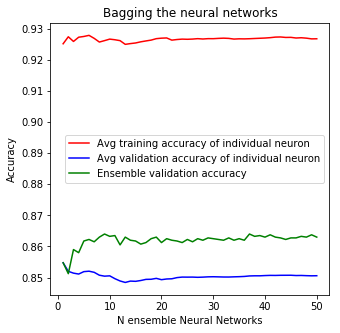

In [42]:
# Function to get explicit ensemble model accuracy from softmax
def getEnsembleAccuracy(Predictions,Yval):
    ypred = []
    # undo one hot encoding
    for i in Predictions:
        ypred.append(Unencode(i).astype(int))
    # Average the predictions and get final predictions
    ypmean=np.mean(ypred,axis=0)
    ypred = (ypmean > 0.5).astype(int)
    
    # Get explicit accuracy
    ytrue = Unencode(Yval).astype(int)
    acc = 1.0*np.sum(ypred == ytrue)/len(ytrue)
    return acc

Predictions = np.array(Predictions)
acc = []
for i in range(1,len(Predictions)+1):
    acc.append([np.mean(TrainErr[:i,1]),np.mean(TestErr[:i,1]),getEnsembleAccuracy(Predictions[:i,:],Yval)])

acc = np.array(acc)
    
plt.figure(2,figsize=(5,5))
plt.title('Bagging the neural networks')
plt.ylabel('Accuracy')
plt.xlabel('N ensemble Neural Networks')
plt.plot(np.arange(1,51),acc[:,0],label='Avg training accuracy of individual neuron',color='red')
plt.plot(np.arange(1,51),acc[:,1],label='Avg validation accuracy of individual neuron',color='blue')
plt.plot(np.arange(1,51),acc[:,2],label='Ensemble validation accuracy',color='green')
plt.legend()
plt.savefig('NNbag.png')
plt.show()

In [142]:
# Random neuron forest
def getDNNForestCross(k,N_models,x_tall,y_tall):
    # Storage for k fold cross validation
    facc = []
    
    # Split the training data k-fold number of ways for k-fold validation of the learning algorithm
    k=5
    kf = sklearn.model_selection.KFold(n_splits=k)
    inds = [ind for ind in kf.split(x_tall, y_tall)]

    j=0
    for train,val in inds:
        print('Cross fold validation ',j+1,'/',k)
        # Training and validation data for k fold cross validation
        Xtrain = x_tall[train]
        Ytrain = y_tall[train]
        Xval = x_tall[val]
        Yval = y_tall[val]

        # Store predictions from each tree in DNN forest
        Predictions = []
        
        # Define the DNN model
        for i in range(0,N_models):
            print('Training DNN ',i)
            model = getModel([500,250,125],0)
            # Compile it and fit
            model.compile(loss='categorical_crossentropy',optimizer='RMSprop', metrics=['accuracy'])
            model.fit(Xtrain, Ytrain, batch_size=2**8, epochs=2,verbose=1)

            # Use weakly trained model to predict and store predictions
            ypred = model.predict(Xval,batch_size=2**8,verbose=1)
            Predictions.append(ypred)

        Predictions = np.array(Predictions)
        
        ypred = []
        for i in Predictions:
            ypred.append(Unencode(i).astype(int))

        # Get mean and standard deviation of samples
        ypmean=np.mean(ypred,axis=0)
        std=np.std(ypred,axis=0)
        print('Number of samples where stdev > 0, ',np.sum(std>0))
        
        # Compute accuracy of predictions
        ypred = (ypmean > 0.5).astype(int)
        ytrue = Unencode(Yval).astype(int)
        acc = 1.0*np.sum(ypred == ytrue)/len(ytrue)
        print('Final accuracy of random forest = ',acc)
        j=j+1
        facc.append(acc)
        
    print('avg Accuracy of all random forests',np.mean(facc))

In [143]:
getDNNForestCross(5,10,x_tall,y_tall)

Cross fold validation  0 / 5
Training DNN  0
Epoch 1/2
16000/16000 [==============================] - 13s 797us/step - loss: 0.4342 - acc: 0.8000
Epoch 2/2
4000/4000 [==============================] - 5s 1ms/step
Training DNN  1
Epoch 1/2
16000/16000 [==============================] - 14s 844us/step - loss: 0.4393 - acc: 0.7969
Epoch 2/2
4000/4000 [==============================] - 5s 1ms/step
Training DNN  2
Epoch 1/2
16000/16000 [==============================] - 13s 813us/step - loss: 0.4315 - acc: 0.8037
Epoch 2/2
4000/4000 [==============================] - 5s 1ms/step
Training DNN  3
Epoch 1/2
16000/16000 [==============================] - 14s 849us/step - loss: 0.4482 - acc: 0.7908
Epoch 2/2
4000/4000 [==============================] - 5s 1ms/step
Training DNN  4
Epoch 1/2
16000/16000 [==============================] - 15s 914us/step - loss: 0.4264 - acc: 0.8039
Epoch 2/2
4000/4000 [==============================] - 6s 1ms/step
Training DNN  5
Epoch 1/2
16000/16000 [============

### Output final predictions from the model

In [ ]:
# Specify number of Neural networks to train
N_models = 20
Predictions = []

# Define the DNN model
for i in range(0,N_models):
    print('Training DNN ',i)
    model = getModel([500,250,125],0.4)
    # Compile it and fit
    model.compile(loss='categorical_crossentropy',optimizer='RMSprop', metrics=['accuracy'])
    model.fit(x_tall, y_tall, batch_size=2**8, epochs=2)
    # Use weakly trained model to predict and store predictions
    ypred = model.predict(FV_data,batch_size=2**8)
    Predictions.append(ypred)

In [ ]:
Predictions = np.array(Predictions)

ypred = []
for i in Predictions:
    ypred.append(Unencode(i).astype(int))

# Get mean and standard deviation of samples
ypmean=np.mean(ypred,axis=0)
std=np.std(ypred,axis=0)
print('Number of samples where stdev > 0, ',np.sum(std>0))

# Compute final predictions and output it
ypred = (ypmean > 0.5).astype(int)
writeResults(ypred)